<a href="https://colab.research.google.com/github/orodriguezq/orodriguezq-Senales_Y_Sistemas/blob/main/Talleres/Taller_2_SyS_Punto6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================
# Bloque 0: Instalación de dependencias
# ==============================
!pip install --upgrade numpy scipy pandas matplotlib


In [2]:
# ==============================
# Bloque 1: Imports y definición de parámetros
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Parámetros de la fuente
f0 = 50                      # frecuencia fundamental [Hz]
w0 = 2 * np.pi * f0
T0 = 1 / f0

# Muestreo y tiempo
N_periods = 5
samples_per_period = 2048
fs = samples_per_period * f0   # frecuencia de muestreo [Hz]
t = np.linspace(0, N_periods * T0, N_periods * samples_per_period, endpoint=False)


In [3]:
# ==============================
# Bloque 2: Señal rectificada y función de cálculo de THD
# ==============================
# i_rect: carga puramente resistiva → i(t) = |sin(w0 t)|
i_rect = np.abs(np.sin(w0 * t))

def compute_thd(signal, fs, fundamental_freq, nharmonics=10):
    """
    Calcula THD y factor de distorsión del factor de potencia
    usando los primeros `nharmonics` armónicos.
    """
    N = len(signal)
    Y = np.fft.fft(signal) / N
    freqs = np.fft.fftfreq(N, d=1/fs)

    # extrae amplitudes
    amps = {}
    for n in range(1, nharmonics+1):
        idx = np.argmin(np.abs(freqs - n*fundamental_freq))
        amps[n] = 2 * np.abs(Y[idx])

    A1 = amps[1]
    harm_sq = sum(amps[n]**2 for n in range(2, nharmonics+1))
    THD = np.sqrt(harm_sq) / A1
    PF_distortion = 1 / np.sqrt(1 + THD**2)
    return THD, PF_distortion, amps

# Cálculo THD y PF para carga resistiva
THD_res, PF_res, amps_res = compute_thd(i_rect, fs, f0, nharmonics=10)
print(f"Resistiva → THD = {THD_res:.4f}, PF_distortion = {PF_res:.4f}")


Resistiva → THD = 10164455022933840.0000, PF_distortion = 0.0000


In [4]:
# ==============================
# Bloque 3: Cálculo para carga RC en serie y tabla de resultados
# ==============================
R = 100        # ohm
C_values = [10e-6, 100e-6, 1e-3]   # Faradios a probar
results = []

for C in C_values:
    # ganancia en cada armónico
    H = lambda n: 1/np.sqrt(1 + (n * w0 * R * C)**2)
    amps_rc = {n: amps_res[n]*H(n) for n in amps_res}
    A1_rc = amps_rc[1]
    harm_sq_rc = sum(amps_rc[n]**2 for n in range(2, 11))
    THD_rc = np.sqrt(harm_sq_rc) / A1_rc
    PF_rc = 1 / np.sqrt(1 + THD_rc**2)
    results.append({
        'C [µF]': C*1e6,
        'THD': THD_rc,
        'PF_distortion': PF_rc
    })

df = pd.DataFrame(results)
display(df.style.format({'THD':'{:.4f}', 'PF_distortion':'{:.4f}'}))


,C [µF],THD,PF_distortion
0,10.000000,8908530571269296.0000,0.0000
1,100.000000,5167660789698771.0000,0.0000
2,1000.000000,4987568429092399.0000,0.0000


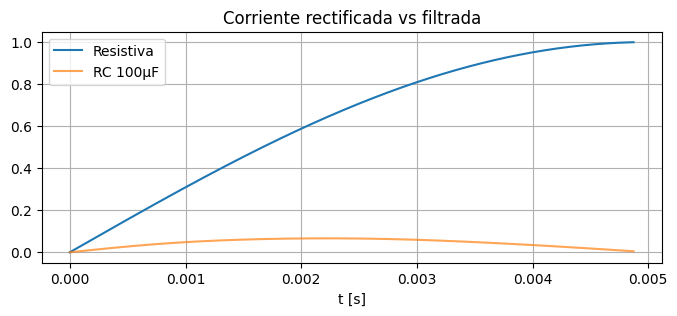

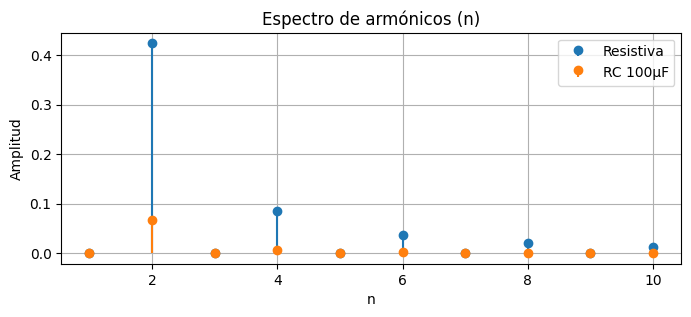

In [5]:
# ==============================
# Bloque 4: Gráficas en tiempo y espectro de armónicos
# ==============================
# Seleccionamos hasta el armónico 10
NH = 10
N = len(i_rect)
Y = np.fft.fft(i_rect)/N
freqs = np.fft.fftfreq(N, d=1/fs)

# amplitudes originales
amps_rect = {n: 2*abs(Y[np.argmin(abs(freqs - n*f0))]) for n in range(1, NH+1)}

# amplitudes con RC = 100µF
C = 100e-6
H = lambda n: 1/np.sqrt(1 + (n * w0 * R * C)**2)
amps_filt = {n: amps_rect[n]*H(n) for n in amps_rect}

# reconstrucción aproximada de la señal filtrada
i_filt = np.zeros_like(t)
for n in range(1, NH+1):
    i_filt += amps_filt[n] * np.sin(n*w0*t)

# 4.1 Dominio del tiempo (primeros 500 muestras)
plt.figure(figsize=(8,3))
plt.plot(t[:500], i_rect[:500], label='Resistiva')
plt.plot(t[:500], i_filt[:500], label='RC 100µF', alpha=0.7)
plt.title('Corriente rectificada vs filtrada')
plt.xlabel('t [s]')
plt.legend()
plt.grid(True)

# 4.2 Espectro de armónicos
harm = list(amps_rect.keys())
plt.figure(figsize=(8,3))
plt.stem(harm, [amps_rect[n] for n in harm], basefmt=" ", label='Resistiva')
plt.stem(harm, [amps_filt[n] for n in harm], basefmt=" ", linefmt='C1-', markerfmt='C1o', label='RC 100µF')
plt.title('Espectro de armónicos (n)')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
